# SIFT

In [21]:
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter
from skimage.transform import resize
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve 

(1024, 677, 3)


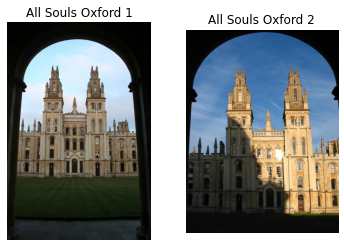

In [41]:
img1 = imread('all_souls_000002.jpg')
img2 = imread('all_souls_000015.jpg')
print(img1.shape)
plt.figure(figsize=(6,4))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('All Souls Oxford 1')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('All Souls Oxford 2')

plt.show()

## Step 1: Scale Space Extrema Detection

In [25]:
img = rgb2gray(img1)

In [67]:
def generate_octaves(im, num_octave, s, sigma):
    k = 2**(1/s)
    octaves = []
    for i in range(num_octave):
        octa = [im]
        for i in range(s):
            im = gaussian_filter(im, k*sigma)
            octa.append(im)
        octaves.append(octa)
        #Down sampling
        im = resize(im, (int(0.5*im.shape[0]), int(0.5*im.shape[1])))
    return octaves

In [68]:
sigma = 1
num_octaves = 4
s = 6
octaves = generate_octaves(img, num_octaves, s, sigma)

In [103]:
def generate_DOG_octaves(gaussian_octaves):
    DoG_octaves = []
    for octave in gaussian_octaves:
        DoG_oct = []
        for i in range(1, len(octave)):
            DoG_oct.append(octave[i] - octave[i-1])
        DoG_octaves.append(np.concatenate([o[:,:,np.newaxis] for o in DoG_oct], axis=2))
    return DoG_octaves

In [104]:
DoG_oct = generate_DOG_octaves(octaves)
print(DoG_oct[0].shape)
# s=6 images per set

(1024, 677, 6)


In [ ]:
def patch_3_3(im, i, j):
    return 

In [153]:
def get_candidate_keypoints(octa):
    keypoints = []
    for i in range(1, len(octa)-2): # parcours les abscisses d'un élément de l'octave
        for j in range(1, len(octa[0])-2): # parcours les ordonées d'un élément de l'octave
            for k in range(1, len(octa[0][0])-2): # parcours les 6 éléments de l'octave
                patch = octa[i-1:i+2, j-1:j+2, k-1:k+2] # patch de pas 1
                if np.argmax(patch) == 13 or np.argmin(patch) == 13:
                    keypoints.append([i,j,k])
    return keypoints

In [154]:
octa = DoG_oct[0]
cand_kpts = get_candidate_keypoints(octa)

In [155]:
print(len(cand_kpts))

46557


## Step 2: Keypoint Localization

### Subpixel Localization

In [215]:
def Jacobian(D, x, y, s):
    dy = (D[x,y+1,s]-D[x,y-1,s])/2 
    dx = (D[x+1,y,s]-D[x-1,y,s])/2 
    ds = (D[x,y,s+1]-D[x,y,s-1])/2 # dérivée par rapport à s? Pourquoi?
    return np.array([dx, dy, ds])

def Hessian(D, x, y, s):
    dyy = D[x,y+1,s]-2*D[x,y,s]+D[x,y-1,s] 
    dxy = ((D[x+1,y+1,s]-D[x+1,y-1,s]) - (D[x-1,y+1,s]-D[x-1,y-1,s]))/4. 
    dys = ((D[x,y+1,s+1]-D[x,y-1,s+1]) - (D[x,y+1,s-1]-D[x,y-1,s-1]))/4. 
    dxx = D[x+1,y,s]-2*D[x,y,s]+D[x-1,y,s] 
    dxs = ((D[x+1,y,s+1]-D[x-1,y,s+1]) - (D[x+1,y,s-1]-D[x-1,y,s-1]))/4. 
    dss = D[x,y,s+1]-2*D[x,y,s]+D[x,y,s-1] 
    return np.array([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])

In [216]:
def localize_keypoint(D, x, y, s):
    # Jacobian and Hessian
    J = Jacobian(D, x, y, s)
    H = Hessian(D, x, y, s)

    # Offset
    offset = -np.linalg.inv(H).dot(J)

    return offset, J, H[:2,:2], x, y, s

In [217]:
x, y, s = cand_kpts[0]
local_kpt = localize_keypoint(octa, x, y, s)
print(local_kpt)
# s indique maintenant pour une octave donnée, la position de l'image où le keypoint a été trouvé 

(array([ 0.44088918, -0.24577117,  0.20704262]), array([ 9.42183126e-05, -6.29764372e-05,  2.14879863e-04]), array([[-1.88983052e-04,  9.05874690e-06],
       [ 9.05874690e-06, -2.01910202e-04]]), 1, 3, 1)


In [220]:
def find_keypoints_for_DoG_octave(D, t_c, R_th):
    candidates = get_candidate_keypoints(D)
    keypoints = []

    for i, cand in enumerate(candidates):
        x, y, s = cand[0], cand[1], cand[2] #pourquoi ces inversions de x, y
        offset, J, H, x, y, s = localize_keypoint(D, x, y, s)

        contrast = D[x,y,s] + .5*J.dot(offset)
        if abs(contrast) >= t_c:
            w, v = np.linalg.eig(H)
            r = w[1]/w[0]
            R = (r+1)**2 / r
            if R <= R_th:
                kp = np.array([x, y, s]) + offset #Pourquoi cette inversion??????
                keypoints.append(kp)

    return np.array(keypoints)

In [221]:
dx_thres = 0.03
r = 10

keypoints = find_keypoints_for_DoG_octave(octa, dx_thres, r)
print(keypoints)
# s est légèrement transformé par l'offset

[[ 82.01071869 290.88049133   1.20588095]
 [ 82.9990563  353.71370935   1.20756662]
 [ 83.64543865 362.59351341   1.20734238]
 ...
 [728.66494474 177.22260441   1.1840829 ]
 [728.49430599 235.14588451   1.19544346]
 [729.14087603 399.38093632   1.24910823]]


In [222]:
print(len(keypoints))

1987


In [223]:
def get_all_keypoints(DOG_octaves,dx_thres, r):
    kpts = []
    for D in DOG_octaves:
        kpts.append(find_keypoints_for_DoG_octave(D, dx_thres, r))
    return kpts

In [224]:
all_keypoints = get_all_keypoints(DoG_oct,dx_thres, r)

## Step 3: Orientation Assignement

In [233]:
def get_m_theta(L, x, y):
    # print(x, y)
    dx = L[min(L.shape[0]-1, x+1),y] - L[max(0, x-1),y]
    dy = L[x,min(L.shape[1]-1, y+1)] - L[x,max(0, y-1)]
    m = np.sqrt(dx**2 + dy**2)
    theta = (np.arctan2(dx, dy)+np.pi) * 180/np.pi
    return m, theta

def quantize_orientation(theta, num_bins):
    bin_width = 360//num_bins
    return int(np.floor(theta)//bin_width)

In [234]:
def neighborhood(img, x, y, size):
    # size is an even number
    n, p = img.shape
    N = size//2
    patch = img[max(x-N,0): min(x+N, n),max(y-N,0): min(y+N, p)]
    return patch

In [246]:
def assign_orientation(im, kps, octave, w=16, num_bins=36):
    new_kps = []
    bin_width = 360//num_bins

    for kp in kps:
        x, y, s = int(kp[0]), int(kp[1]), kp[2]

        # weighted by its gradient magnitude and by a Gaussian-weighted circular window with a σ that is 1.5 times that of the scale of the keypoint
        sigma = kp[2]*1.5
        L = octave[:,:,int(s)]
        hist = np.zeros(num_bins, dtype=np.float32)
        hist = np.zeros((num_bins,1))
        patch = neighborhood(L, x, y, w)
        print(x, y)
        for i in range(int(w//2)):
            for j in range(int(w//2)):
                if x+i < L.shape[0]-2 and y+j < L.shape[1]-2:
                    m1, theta1 = get_m_theta(L, x+i, y+j)
                    ind1 = int(theta1//num_bins)
                    hist[ind1] += m1
                if x+i < L.shape[0]-2 and y-j >= 0:
                    m2, theta2 = get_m_theta(L, x+i, y-j)
                    ind2 = int(theta2//num_bins)
                    hist[ind2] += m2
                if x-i >= 0 and y-j >= 1:
                    m3, theta3 = get_m_theta(L, x-i, y-j)
                    ind3 = int(theta3//num_bins)
                    hist[ind3] += m3
                if x-i >= 0 and y+j < L.shape[1]-2:
                    m4, theta4 = get_m_theta(L, x-i, y+j)
                    ind4 = int(theta4//num_bins)
                    hist[ind4] += m4

        grad, orient = np.amax(hist), np.argmax(hist)*num_bins
        new_kps.append(np.array([x, y, sigma, orient]))

    return np.array(new_kps)

In [247]:
new_kps = assign_orientation(img, all_keypoints[0], octa, w=16, num_bins=36)

82 290
82 353
83 362
85 377
94 235
96 229
100 429
105 440
115 467
119 468
123 180
123 474
128 482
132 160
132 490
140 499
140 150
141 155
142 508
144 150
143 505
149 145
154 135
157 132
157 136
161 524
160 528
169 125
205 214
206 236
206 399
206 421
207 211
207 216
207 233
207 239
208 396
208 402
208 418
208 424
209 213
209 235
210 399
210 422
212 210
212 232
212 239
212 217
212 395
212 403
213 418
213 426
214 210
215 216
214 232
215 396
216 219
215 419
215 424
217 209
217 231
217 394
217 416
218 216
217 238
218 397
218 404
218 426
218 418
219 219
219 240
219 394
220 416
221 210
222 217
221 232
222 239
222 402
222 396
223 418
222 425
224 220
224 242
225 208
224 230
224 393
225 405
224 415
225 427
227 220
226 240
226 395
227 226
227 232
228 409
228 414
228 208
229 242
228 403
229 213
229 223
229 393
229 427
230 411
232 208
232 240
232 223
232 394
233 412
233 427
235 244
235 391
236 213
237 232
237 206
238 217
237 402
237 422
237 429
238 241
239 393
240 207
240 211
241 428
241 244
242 39

IndexError: index 717 is out of bounds for axis 1 with size 677

In [240]:
print(octa.shape)

(1024, 677, 6)
